In [107]:
import numpy as np
import json
from munch import Munch
import itertools
from collections import defaultdict
import random
import copy
import pickle
import torch
import importlib
import time

import apt_helper as ahlp
import apt_cst_aggregate as cagg
import mv_Viterbi as mv

import matplotlib.pyplot as plt

In [2]:
names = ['apt','bob','sally']
mu_list = [.8,.9,.9]
apt_hmm, bob_hmm, sally_hmm = ahlp.process_load(names, delay = mu_list)
user_list = [bob_hmm, sally_hmm]

In [3]:
#Check if correctly loaded. probabilities should sum to 1.
for usr in user_list:
    usr_params = ahlp.hmm2numpy(usr)
    print(f'initprob:{usr_params[0].sum()}  tprob: {usr_params[1].sum(axis = 1)}  eprob: {usr_params[2].sum(axis = 1)}')

initprob:1.0  tprob: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]  eprob: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
initprob:1.0  tprob: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]  eprob: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [4]:
apt_params = ahlp.hmm2numpy(apt_hmm)
print(f'initprob:{apt_params[0].sum()}  tprob: {apt_params[1].sum(axis = 1)}  eprob: {apt_params[2].sum(axis = 1)}')

initprob:1.0  tprob: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]  eprob: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [5]:
cst_names = ['know_sally_exists','have_sally_credential', 'learn_where_data_stored', 'have_data_on_ds', 'have_data_on_hi', 'have_data_on_he']
cst_names = [names + '_TRUE' for names in cst_names]
cst_list=  []
for name in cst_names:
    module = importlib.import_module(name)
    
    curr_cst =  Munch(name = module.name, \
                      aux_size = module.aug_size, \
                      update_fun = module.update_fun, \
                      init_fun = module.init_fun, \
                      forbidden_emissions = module.forbidden_emissions, \
                      forbidden_transitions = module.forbidden_transitions, \
                      knowledge_state = module.knowledge_state, \
                      cst_fun = module.cst_fun)
    if hasattr(module, 'dependency'):
        curr_cst.dependency = module.dependency
    cst_list.append(curr_cst)

sat = len(cst_list) * (True,)

In [ ]:
def Viterbi_torch_list(hmm, cst_list, obs, sat,  time_hom = True, dtype = torch.float16,  device = 'cpu', debug = False, num_cst = 0):
    '''
    more optimized torch implementation of Viterbi. The constraint all evolve independently (ie. factorial), so no need to create a big U_krjs matrix. Instead, just multiply along given dim. Still require computing V_{krjs}, but this should help.
    For numerica underflow, we normalize the value at each time. Also, we add a small constant num_cst when normalizing.
    '''
    hmm = copy.deepcopy(hmm) #protect again in place modification
    #Generate emit_weights:
    emit_weights = compute_emitweights(obs, hmm, time_hom)
    emit_weights = torch.from_numpy(emit_weights).type(torch.float16).to(device)

    #Generate hmm,cst params:
    hmm_params, cst_params_list, state_ix = convertTensor_list(hmm,cst_list, sat, dtype = dtype, \
                                                               device = device, return_ix = True)   
    tmat, init_prob = hmm_params
    dims_list, init_ind_list,final_ind_list,ind_list = cst_params_list

    
    #Viterbi
    T = emit_weights.shape[0]
    K = tmat.shape[0]
    C = len(dims_list)
    
    val = torch.empty((T,K) + tuple(dims_list), device = 'cpu')
    ix_tracker = torch.empty((T,K) + tuple(dims_list), device = 'cpu') #will store flattened indices
    
    kr_indices = list(range(C+1))
    kr_shape = (K,) + tuple(dims_list)
    js_indices = [k + C + 1 for k in kr_indices]

    #Forward pass
    # V = torch.einsum('k,k,kr -> kr', init_prob, emit_weights[0], init_ind)
    V = torch.einsum(emit_weights[0], [0], init_prob, [0], *init_ind_list, kr_indices)
    V = V/(V.max() + num_cst) #normalize for numerical stability
    val[0] = V.cpu()
    for t in range(1,T):
        # V = torch.einsum('js,jk,krjs -> krjs',val[t-1],tmat,ind)
        V = torch.einsum(val[t-1].to(device), js_indices, tmat, [C+1,0], *ind_list, list(range(2*C + 2)))
        V = V.reshape(tuple(kr_shape) + (-1,))
        V = V/(V.max() + num_cst)
        max_ix = torch.argmax(V, axis = -1, keepdims = True)
        ix_tracker[t-1] = max_ix.squeeze()
        V = torch.take_along_dim(V, max_ix, axis=-1).squeeze()
        if t == T:
            # val[t] = torch.einsum('k,kr,kr -> kr',emit_weights[t],final_ind,V)
            val[t] = torch.einsum(emit_weights[t],[0], V, kr_indices,*final_ind_list, kr_indices).cpu()
        else:
            # val[t] = torch.einsum('k,kr -> kr', emit_weights[t],V)
            val[t] = torch.einsum(emit_weights[t],[0], V, kr_indices, kr_indices).cpu()
        
    state_ix = {v:k for k,v in state_ix.items()}
    #Backward pass
    opt_augstateix_list = []
    max_ix = int(torch.argmax(val[T-1]).item())
    unravel_max_ix = np.unravel_index(max_ix, kr_shape)
    opt_augstateix_list =  [np.array(unravel_max_ix).tolist()] + opt_augstateix_list
    
    ix_tracker = ix_tracker.reshape(T,-1) #flatten again for easier indexing    
    
    for t in range(T-1):
        max_ix =  int(ix_tracker[T-2-t,max_ix].item())
        unravel_max_ix = np.unravel_index(max_ix, kr_shape)
        opt_augstateix_list =  [np.array(unravel_max_ix).tolist()] + opt_augstateix_list

    opt_state_list = [state_ix[k[0]] for k in opt_augstateix_list]
    if debug:
        return opt_state_list, opt_augstateix_list, val, ix_tracker
    return opt_state_list, opt_augstateix_list


In [27]:
ordered_apt, wait_list = apt_preprocess(apt_hmm, device = 'cuda:0')

In [157]:
true_hmm_params, cst_params = em_convertTensor(ordered_apt, cst_list, rand_init = False, dtype = torch.float32, device = 'cuda:0', return_ix = False)

In [139]:
B = 50
seq_list = []
for b in range(B):
    apt_truth, combined_emits = ahlp.combined_simulation(apt_hmm, user_list, cst_list)
    seq_list.append(combined_emits)

weight_list = em_emitweights(apt_hmm,seq_list, mix_param = .81)

In [20]:
# new_apt, new_params, time_list = apt_EM(apt_hmm, cst_list, seq_list,  device ='cuda:0', conv = 1e-4, max_step = 50, \
#                                         dtype = torch.float32, rand_init = True, mix_param = .81, timer = True)

Step:0, T+E change: 2.548190712928772, Ttl change: 2.9783555484006596, neg log prob: 2611.8402557373047
Step:1, T+E change: 1.109195053577423, Ttl change: 1.1671581321398274, neg log prob: 2597.429656982422
Step:2, T+E change: 0.5564272105693817, Ttl change: 0.5661527748689135, neg log prob: 2598.7288970947266
Step:3, T+E change: 0.49185022711753845, Ttl change: 0.4953423718969192, neg log prob: 2593.9630432128906
Step:4, T+E change: 0.45290081202983856, Ttl change: 0.45777937968576543, neg log prob: 2596.7220611572266
Step:5, T+E change: 0.43334367871284485, Ttl change: 0.43563609791485014, neg log prob: 2593.2415466308594
Step:6, T+E change: 0.40707068145275116, Ttl change: 0.4138088809050381, neg log prob: 2595.282516479492
Step:7, T+E change: 0.3914366066455841, Ttl change: 0.39324135111530234, neg log prob: 2592.406723022461
Step:8, T+E change: 0.3709263205528259, Ttl change: 0.3782079682671122, neg log prob: 2593.8546752929688
Step:9, T+E change: 0.37485412508249283, Ttl change: 

In [140]:
new_apt, new_params, time_list = apt_EM_v2(apt_hmm, cst_list, seq_list,  device ='cuda:0', conv = 1e-4, max_step = 100, \
                                        dtype = torch.float32, rand_init = True, mix_param = .81, timer = True, fix_mu = None)

Step:0, neg log prob: 13735.748237609863, log_prob_change %: 0.006479366518674645
Step:1, neg log prob: 13664.607292175293, log_prob_change %: 0.0051792551962898704
Step:2, neg log prob: 13511.999881744385, log_prob_change %: 0.011168078757616046
Step:3, neg log prob: 13378.276481628418, log_prob_change %: 0.009896640118879519
Step:4, neg log prob: 13307.497821807861, log_prob_change %: 0.0052905663833269344
Step:5, neg log prob: 13267.341060638428, log_prob_change %: 0.003017604188792434
Step:6, neg log prob: 13245.952835083008, log_prob_change %: 0.0016120958568612176
Step:7, neg log prob: 13233.714744567871, log_prob_change %: 0.0009239116783447332
Step:8, neg log prob: 13226.331703186035, log_prob_change %: 0.0005578963672967564
Step:9, neg log prob: 13221.69995880127, log_prob_change %: 0.0003501911556966248
Step:10, neg log prob: 13218.623413085938, log_prob_change %: 0.00023268911901786664
Step:11, neg log prob: 13216.427806854248, log_prob_change %: 0.00016609946157599784
Step:

In [151]:
sum(time_list)/len(time_list)

8.715791314840317

In [173]:
new_params[3]

0.8932236706620164

In [158]:
_, _, true_log_prob, debug_prob_list, message_list = apt_BW(weight_list, true_hmm_params,cst_params, debug = True)
og_gamma, og_xi = message_list
print(f'original log prob {-1*-1*true_log_prob}')
print(og_gamma.sum(dim=(1,2)))
print(og_xi)

original log prob -14088.711387634277
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
  

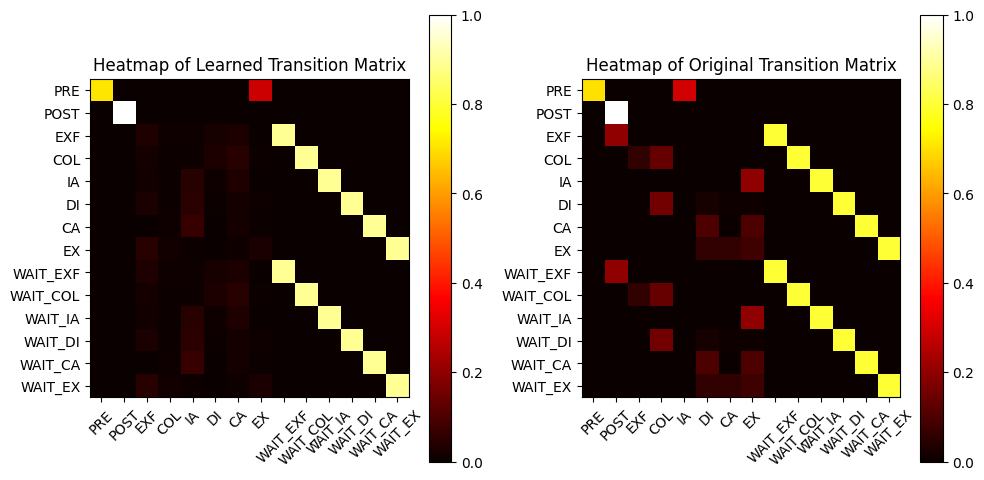

In [160]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot the first heatmap
# cax1 = axes[0].imshow(new_params[0][:(2+L),:(2+L)].cpu(), cmap='hot', interpolation='nearest')
cax1 = axes[0].imshow(new_params[0].cpu(), cmap='hot', interpolation='nearest')
axes[0].set_title('Heatmap of Learned Transition Matrix')
axes[0].set_xticks(np.arange(len(list(ordered_apt.states))))
axes[0].set_xticklabels(list(ordered_apt.states), rotation=45)
axes[0].set_yticks(np.arange(len(list(ordered_apt.states))))
axes[0].set_yticklabels(list(ordered_apt.states))

fig.colorbar(cax1, ax=axes[0])

# Plot the second heatmap
# cax2 = axes[1].imshow(hmm_params[0][:(2+L),:(2+L)].cpu(), cmap='hot', interpolation='nearest')
cax2 = axes[1].imshow(hmm_params[0].cpu(), cmap='hot', interpolation='nearest')
axes[1].set_title('Heatmap of Original Transition Matrix')
axes[1].set_xticks(np.arange(len(list(ordered_apt.states))))
axes[1].set_xticklabels(list(ordered_apt.states), rotation=45)
axes[1].set_yticks(np.arange(len(list(ordered_apt.states))))
axes[1].set_yticklabels(list(ordered_apt.states))

fig.colorbar(cax2, ax=axes[1])

# Show the plots
plt.tight_layout()
plt.show()


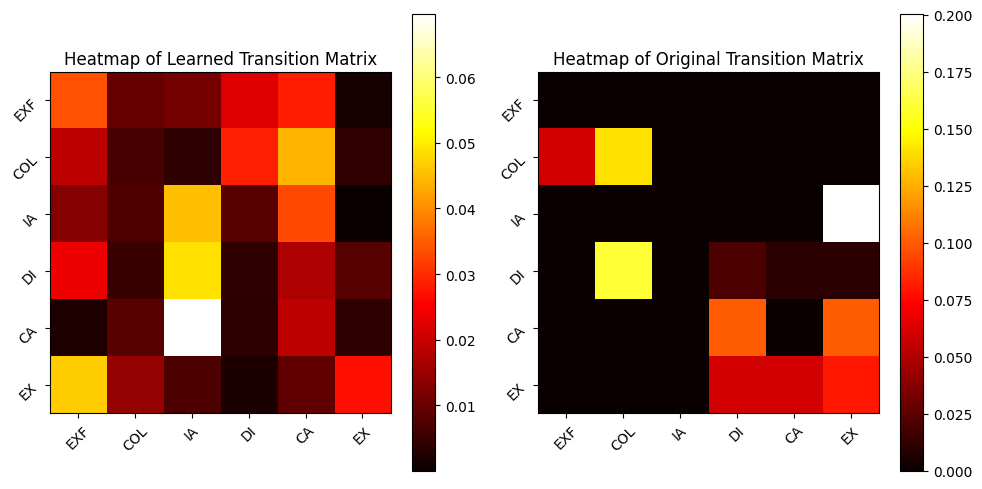

In [171]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
og_states = ordered_apt.states[2:(2+L)]
# Plot the first heatmap
cax1 = axes[0].imshow(new_params[0][2:(2+L),2:(2+L)].cpu(), cmap='hot', interpolation='nearest')
# cax1 = axes[0].imshow(new_params[0].cpu(), cmap='hot', interpolation='nearest')
axes[0].set_xticks(np.arange(len(og_states)))
axes[0].set_xticklabels(og_states, rotation=45)
axes[0].set_yticks(np.arange(len(og_states)))
axes[0].set_yticklabels(og_states, rotation=45)

axes[0].set_title('Heatmap of Learned Transition Matrix')
fig.colorbar(cax1, ax=axes[0])

# Plot the second heatmap
cax2 = axes[1].imshow(hmm_params[0][2:(2+L),2:(2+L)].cpu(), cmap='hot', interpolation='nearest')
# cax2 = axes[1].imshow(hmm_params[0].cpu(), cmap='hot', interpolation='nearest')
axes[1].set_xticks(np.arange(len(og_states)))
axes[1].set_xticklabels(og_states, rotation=45)
axes[1].set_yticks(np.arange(len(og_states)))
axes[1].set_yticklabels(og_states, rotation=45)


axes[1].set_title('Heatmap of Original Transition Matrix')
fig.colorbar(cax2, ax=axes[1])

# Show the plots
plt.tight_layout()
plt.show()


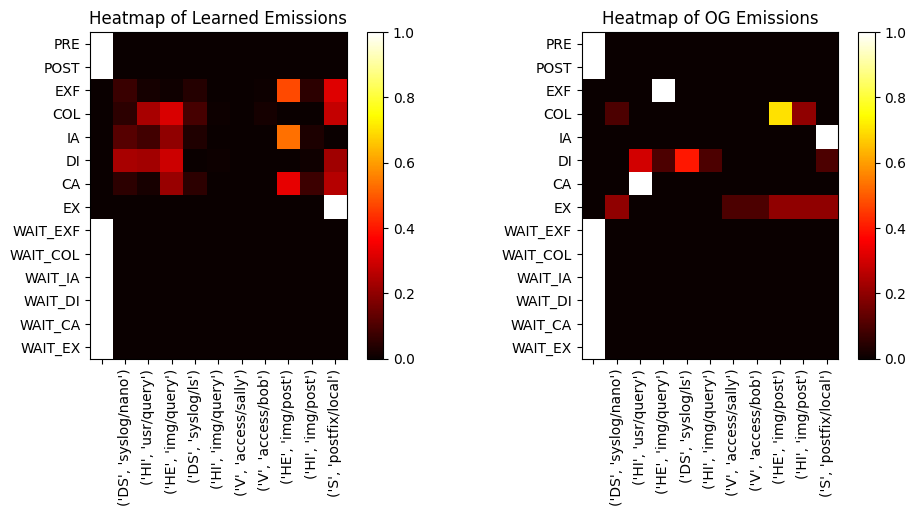

In [167]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot the first heatmap
cax1 = axes[0].imshow(new_params[1].cpu(), cmap='hot', interpolation='nearest')
axes[0].set_title('Heatmap of Learned Emissions')
axes[0].set_xticks(np.arange(len(list(ordered_apt.emits))))
axes[0].set_xticklabels(list(ordered_apt.emits), rotation=90)
axes[0].set_yticks(np.arange(len(list(ordered_apt.states))))
axes[0].set_yticklabels(list(ordered_apt.states))

fig.colorbar(cax1, ax=axes[0])

# Plot the second heatmap
cax2 = axes[1].imshow(hmm_params[1].cpu(), cmap='hot', interpolation='nearest')
axes[1].set_title('Heatmap of OG Emissions')
axes[1].set_xticks(np.arange(len(list(ordered_apt.emits))))
axes[1].set_xticklabels(list(ordered_apt.emits), rotation=90)
axes[1].set_yticks(np.arange(len(list(ordered_apt.states))))
axes[1].set_yticklabels(list(ordered_apt.states))

fig.colorbar(cax2, ax=axes[1])

# Show the plots
plt.tight_layout()
plt.show()


In [395]:
sum(time_list)/len(time_list)

1.7371300762774897

In [348]:
hmm_params[1].sum(dim=1)

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000], device='cuda:0')

In [349]:
B = 10
seq_list = []
for b in range(B):
    apt_truth, combined_emits = ahlp.combined_simulation(apt_hmm, user_list, cst_list)
    seq_list.append(combined_emits)

weight_list = em_emitweights(ordered_apt,seq_list)

In [350]:
ttl_gamma, ttl_xi, log_prob, debug_prob_list = apt_BW(weight_list, hmm_params,cst_params, debug = True)

In [368]:
new_hmm_params =  apt_Mstep(hmm_params,wait_list, ttl_gamma, ttl_xi)

In [372]:
new_hmm_params[3]

0.16352451601786186

In [376]:
A[2:(2+L),(2+L):].shape

torch.Size([6, 6])

In [377]:
    A_old , B_old, pi, _ = hmm_params
    wait_ix, delay_ix, L = wait_list

    A = torch.zeros(A_old.shape)
    B = B_old.clone()
    
    #update the mu parameter
    mu_const = torch.einsum('cjk,jk -> c',delay_ix, ttl_xi)
    mu = 1/(1+(mu_const[0].item()/mu_const[1].item())) #mu^* = 1/(1+C1/C2)
    
    #update the PRE > PRE,POST,OG transitions.
    A[0,:(2+L)] = ttl_xi[0,:(2+L)]/ttl_xi[0,:(2+L)].sum() #usual update eqn  for PRE

    #update STATE > POST, STATE transitions
    state_xi = torch.einsum('ij,jk -> ik', wait_ix, ttl_xi) #sum messages for OG and WAIT analogue. Transitions to POST, OG only
    ogA = state_xi[:,1:(2+L)]/state_xi[:,1:(2+L)].sum(dim = 1, keepdim=True)
    A[1,1] = 1. #POST absorbing
    A[2:(2+L), 1:(2+L)] = (1-mu)*ogA #fill in OG > POST, OG
    A[(2+L):, 1:(2+L)] = (1-mu)*ogA #copy WAIT > POST,OG

    #update transition to WAIT
    A[2:(2+L),(2+L):] = mu*torch.eye(L).to(device) #OG > WAIT
    A[(2+L):,(2+L):] = mu*torch.eye(L).to(device) #WAIT > WAIT

    #update emission matrix.
    #only update STATE emissions. PRE, POST, WAIT all fixed to None. OG cannot emit None
    B[2:(2+L),1:] = ttl_gamma[2:(2+L),1:]/ttl_gamma[2:(2+L),1:].sum(dim=1,keepdim=True)


In [378]:
ttl_xi[1,:]/ttl_xi[1,:].sum()

tensor([0.0729, 0.0303, 0.0622, 0.1178, 0.0663, 0.0714, 0.0786, 0.0831, 0.0598,
        0.0765, 0.0680, 0.0673, 0.0711, 0.0745], device='cuda:0')

In [379]:
A

tensor([[0.2466, 0.3577, 0.1389, 0.0388, 0.0656, 0.0610, 0.0258, 0.0656, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.3419, 0.1503, 0.0547, 0.0834, 0.0817, 0.0625, 0.0619, 0.1635,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.4058, 0.1326, 0.0492, 0.0750, 0.0663, 0.0528, 0.0548, 0.0000,
         0.1635, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.3479, 0.1461, 0.0485, 0.0875, 0.0811, 0.0647, 0.0607, 0.0000,
         0.0000, 0.1635, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.3412, 0.1438, 0.0563, 0.0864, 0.0819, 0.0624, 0.0644, 0.0000,
         0.0000, 0.0000, 0.1635, 0.0000, 0.0000],
        [0.0000, 0.3435, 0.1454, 0.0494, 0.0794, 0.0858, 0.0613, 0.0716, 0.0000,
         0.0000, 0.0000, 0.0000, 0.1635, 0.0000],
        [0.0000, 0.3671, 0.1354, 0.0568, 0.0854, 0.0761, 0.0595, 0.0561, 0.0000,
  

In [256]:
hmm_params[0]

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0391, 0.0308, 0.1082, 0.1010, 0.1219, 0.1022, 0.0119, 0.0311, 0.0715,
         0.0304, 0.0971, 0.1026, 0.1197, 0.0325],
        [0.0467, 0.1215, 0.0457, 0.0947, 0.0870, 0.0467, 0.0948, 0.1200, 0.0806,
         0.0460, 0.0600, 0.0862, 0.0532, 0.0169],
        [0.0021, 0.0090, 0.1217, 0.0363, 0.1431, 0.0548, 0.0171, 0.1279, 0.0304,
         0.0580, 0.1285, 0.0526, 0.1037, 0.1147],
        [0.0935, 0.0680, 0.0851, 0.0705, 0.0837, 0.1405, 0.1456, 0.0966, 0.0846,
         0.0017, 0.0181, 0.0151, 0.0599, 0.0369],
        [0.0568, 0.0394, 0.0833, 0.0684, 0.1344, 0.0784, 0.0897, 0.0140, 0.0127,
         0.0448, 0.1298, 0.0826, 0.0940, 0.0718],
        [0.0794, 0.0894, 0.0265, 0.1284, 0.0596, 0.0119, 0.0553, 0.0311, 0.0283,
         0.0522, 0.0561, 0.1005, 0.1318, 0.1496],
        [0.0575, 0.0110, 0.0874, 0.1089, 0.0757, 0.0455, 0.0670, 0.0738, 0.0965,
  

In [233]:
A

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0508, 0.0837, 0.0696, 0.0496, 0.0492, 0.0733, 0.0617, 0.0778, 0.0843,
         0.0807, 0.0792, 0.0849, 0.0776, 0.0776],
        [0.0455, 0.0874, 0.0608, 0.0605, 0.0454, 0.0616, 0.0650, 0.0643, 0.0879,
         0.0847, 0.0850, 0.0883, 0.0819, 0.0816],
        [0.0470, 0.0866, 0.0611, 0.0604, 0.0513, 0.0621, 0.0631, 0.0630, 0.0872,
         0.0841, 0.0841, 0.0875, 0.0812, 0.0812],
        [0.0420, 0.0869, 0.0599, 0.0592, 0.0523, 0.0602, 0.0656, 0.0668, 0.0876,
         0.0842, 0.0845, 0.0879, 0.0814, 0.0813],
        [0.0437, 0.0856, 0.0621, 0.0602, 0.0527, 0.0625, 0.0653, 0.0687, 0.0863,
         0.0828, 0.0833, 0.0866, 0.0803, 0.0799],
        [0.0429, 0.0851, 0.0637, 0.0603, 0.0527, 0.0639, 0.0648, 0.0696, 0.0857,
         0.0826, 0.0829, 0.0860, 0.0798, 0.0799],
        [0.0434, 0.0860, 0.0618, 0.0606, 0.0520, 0.0616, 0.0646, 0.0682, 0.0866,
  

In [203]:
new_hmm_params =  apt_Mstep(hmm_params,wait_list, ttl_gamma, ttl_xi)

In [204]:
new_hmm_params[0]

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.1199, 0.0611, 0.0627, 0.0474, 0.0474, 0.0786, 0.0907, 0.0662, 0.0660,
         0.0694, 0.0671, 0.0749, 0.0759, 0.0728],
        [0.1454, 0.0697, 0.0584, 0.0588, 0.0357, 0.0590, 0.0591, 0.0415, 0.0734,
         0.0760, 0.0748, 0.0831, 0.0840, 0.0811],
        [0.1616, 0.0675, 0.0574, 0.0579, 0.0391, 0.0603, 0.0563, 0.0423, 0.0701,
         0.0729, 0.0727, 0.0820, 0.0825, 0.0776],
        [0.1685, 0.0666, 0.0505, 0.0477, 0.0393, 0.0532, 0.0584, 0.0446, 0.0717,
         0.0757, 0.0732, 0.0843, 0.0851, 0.0812],
        [0.1729, 0.0664, 0.0543, 0.0529, 0.0375, 0.0571, 0.0554, 0.0432, 0.0698,
         0.0734, 0.0723, 0.0830, 0.0833, 0.0785],
        [0.1709, 0.0667, 0.0560, 0.0485, 0.0385, 0.0569, 0.0574, 0.0425, 0.0703,
         0.0738, 0.0728, 0.0833, 0.0836, 0.0788],
        [0.1735, 0.0686, 0.0502, 0.0452, 0.0382, 0.0531, 0.0555, 0.0431, 0.0719,
  

In [205]:
hmm_params[0]

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.1199, 0.0611, 0.0627, 0.0474, 0.0474, 0.0786, 0.0907, 0.0662, 0.0660,
         0.0694, 0.0671, 0.0749, 0.0759, 0.0728],
        [0.1454, 0.0697, 0.0584, 0.0588, 0.0357, 0.0590, 0.0591, 0.0415, 0.0734,
         0.0760, 0.0748, 0.0831, 0.0840, 0.0811],
        [0.1616, 0.0675, 0.0574, 0.0579, 0.0391, 0.0603, 0.0563, 0.0423, 0.0701,
         0.0729, 0.0727, 0.0820, 0.0825, 0.0776],
        [0.1685, 0.0666, 0.0505, 0.0477, 0.0393, 0.0532, 0.0584, 0.0446, 0.0717,
         0.0757, 0.0732, 0.0843, 0.0851, 0.0812],
        [0.1729, 0.0664, 0.0543, 0.0529, 0.0375, 0.0571, 0.0554, 0.0432, 0.0698,
         0.0734, 0.0723, 0.0830, 0.0833, 0.0785],
        [0.1709, 0.0667, 0.0560, 0.0485, 0.0385, 0.0569, 0.0574, 0.0425, 0.0703,
         0.0738, 0.0728, 0.0833, 0.0836, 0.0788],
        [0.1735, 0.0686, 0.0502, 0.0452, 0.0382, 0.0531, 0.0555, 0.0431, 0.0719,
  

In [277]:
A, B, pi, mu = hmm_params
ind, init_ind = cst_params
K, E = B.shape
M = ind.size(-1)
device = A.device

ttl_gamma = 0
ttl_xi = 0
debug = True

In [278]:
C_cpu = weight_list[0]
C = C_cpu.to(device)
T = C.size(0)
#First compute D_{jksr} out of loop, which will be reused several times
D = torch.einsum('te,ke,jkesr -> tjksr', C, B, ind)

#Create empty forward/backward messages. 
alpha =  torch.empty((T,K,E,M)).to(device) #for now on GPU. see if run out of memory
beta = torch.empty((T,K,M)).to(device)

#Initialize alpha and beta
alpha[0] = torch.einsum('k,ke,e,ker -> ker', pi, B, C[0], init_ind)
beta[T-1] = 1.

if debug:
    debug_prob_list = []

#Forward messages
for t in range(1,T): #last message no different since compressed formulation
    past_alpha = alpha[t-1].sum(dim = 1) #sum out e
    ind2 = torch.einsum('js, jk, jkesr -> ker', past_alpha, A, ind) #intermediate product. manually split it up since not sure torch will do this.
    alpha[t] = torch.einsum('e,ke,ker -> ker', C[t], B, ind2)

#Backward messages
for t in range(1,T):
    beta[T-1-t] = torch.einsum('js,jk,kjrs -> kr',beta[T-t], A, D[T-t])

#Compute the moments
if debug: #dat prob P(X,C)
    all_dat_prob = torch.einsum('tker,tkr -> t', alpha, beta)
    dat_prob = all_dat_prob[0].item()
    debug_prob_list.append(all_dat_prob.cpu())
else:
    dat_prob = torch.einsum('ker,kr -> ', alpha[0], beta[0]).item()


In [291]:
alpha[3].sum()

tensor(0.0008, device='cuda:0')

In [262]:
init_ind.sum()

tensor(146., device='cuda:0')

In [296]:
beta[T-10]

tensor([[4.0896e-07, 4.0830e-07, 3.7650e-07, 3.7584e-07, 4.0593e-07, 4.0528e-07,
         3.7384e-07, 3.7319e-07, 4.0857e-07, 4.0791e-07, 3.7614e-07, 3.7549e-07,
         4.0555e-07, 4.0489e-07, 3.7349e-07, 3.7284e-07, 3.8886e-07, 3.8823e-07,
         3.5824e-07, 3.5761e-07, 3.8595e-07, 3.8533e-07, 3.5568e-07, 3.5506e-07,
         3.8849e-07, 3.8786e-07, 3.5790e-07, 3.5727e-07, 3.8558e-07, 3.8496e-07,
         3.5534e-07, 3.5472e-07, 4.0804e-07, 4.0738e-07, 3.7564e-07, 3.7499e-07,
         4.0502e-07, 4.0437e-07, 3.7299e-07, 3.7234e-07, 4.0765e-07, 4.0699e-07,
         3.7529e-07, 3.7464e-07, 4.0463e-07, 4.0398e-07, 3.7264e-07, 3.7199e-07,
         3.8795e-07, 3.8732e-07, 3.5740e-07, 3.5677e-07, 3.8505e-07, 3.8443e-07,
         3.5485e-07, 3.5423e-07, 3.8758e-07, 3.8695e-07, 3.5706e-07, 3.5644e-07,
         3.8468e-07, 3.8406e-07, 3.5451e-07, 3.5389e-07],
        [8.2043e-08, 8.1658e-08, 5.6393e-08, 5.6010e-08, 8.0639e-08, 8.0260e-08,
         5.5295e-08, 5.4918e-08, 8.1873e-08, 8.1489

In [164]:
past_alpha = alpha[0].sum(dim = 1)

In [271]:
C_cpu = weight_list[0]
C = C_cpu.to(device)
T = C.size(0)
#First compute D_{jksr} out of loop, which will be reused several times
D = torch.einsum('te,ke,jkesr -> tjksr', C, B, ind)

#Create empty forward/backward messages. 
alpha =  torch.empty((T,K,E,M)).to(device) #for now on GPU. see if run out of memory
beta = torch.empty((T,K,M)).to(device)

#Initialize alpha and beta
alpha[0] = torch.einsum('k,ke,e,ker -> ker', pi, B, C[0], init_ind)
beta[T-1] = 1.

if debug:
    debug_prob_list = []

#Forward messages
for t in range(1,T): #last message no different since compressed formulation
    past_alpha = alpha[t-1].sum(dim = 1) #sum out e
    ind2 = torch.einsum('js, jk, jkesr -> ker', past_alpha, A, ind) #intermediate product. manually split it up since not sure torch will do this.
    alpha[t] = torch.einsum('e,ke,ker -> ker', C[t], B, ind2)

#Backward messages
for t in range(1,T):
    beta[T-1-t] = torch.einsum('js,jk,kjrs -> kr',beta[T-t], A, D[T-t])

#Compute the moments
if debug: #dat prob P(X,C)
    all_dat_prob = torch.einsum('tker,tkr -> t', alpha, beta)
    dat_prob = all_dat_prob[0].item()
    debug_prob_list.append(all_dat_prob.cpu())
else:
    dat_prob = torch.einsum('ker,kr -> ', alpha[0], beta[0]).item()


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu!

In [9]:
    A, B, pi, mu = hmm_params
    ind, init_ind = cst_params
    K, E = B.shape
    M = ind.size(-1)
    device = A.device

    ttl_gamma = 0
    ttl_xi = 0

    for C_cpu in weight_list: #generate the messages for each sequence
        C = C_cpu.to(device)
        T = C.size(0)
        #First compute D_{jksr} out of loop, which will be reused several times
        D = torch.einsum('te,ke,jkesr -> tjksr', C, B, ind)
    
        #Create empty forward/backward messages. 
        alpha =  torch.empty((T,K,E,M)).to(device) #for now on GPU. see if run out of memory
        beta = torch.empty((T,K,M)).to(device)
    
        #Initialize alpha and beta
        alpha[0] = torch.einsum('k,ke,te,ker -> ker', pi, B, C, init_ind)
        beta[T-1] = 1.

        if debug:
            debug_prob_list = []
    
        #Forward messages
        for t in range(1,T): #last message no different since compressed formulation
            past_alpha = alpha[t-1].sum(dim = 1) #sum out e
            ind2 = torch.einsum('js, jk, jkesr -> ker', past_alpha, A, ind) #intermediate product. manually split it up since not sure torch will do this.
            alpha[t] = torch.einsum('e,ke,ker -> ker', C[t], B, ind2)
    
        #Backward messages
        for t in range(1,T):
            beta[T-1-t] = torch.einsum('js,jk,kjrs -> kr',beta[T-t], A, D[T-t])
    
        #Compute the moments
        if debug: #dat prob P(X,C)
            all_dat_prob = torch.einsum('tker,tkr -> t', alpha, beta)
            dat_prob = all_dat_prob[0].item()
            debug_prob_list.append(all_dat_prob.cpu())
        else:
            dat_prob = torch.einsum('ker,kr -> ', alpha[0], beta[0]).item()

        #We'll always sum both moments over time for A,B.
        gamma = 1/dat_prob*torch.einsum('tker,tkr ->  ke', alpha, beta).cpu()
        xi = 1/dat_prob*torch.einsum('tjes,tkr,tjksr -> jk', alpha[:(T-1)],beta[1:],D[1:]).cpu() #xi time index starts at 2.

        ttl_gamma += gamma
        ttl_xi += xi

    if debug:
        return ttl_gamma, ttl_xi, debug_prob_list


['EXF',
 'PRE',
 'EX',
 'DI',
 'CA',
 'POST',
 'COL',
 'IA',
 'WAIT_EXF',
 'WAIT_EX',
 'WAIT_DI',
 'WAIT_CA',
 'WAIT_COL',
 'WAIT_IA']

In [178]:
new_hmm_params,new_cst_params = ahlp.convertTensor_list(ordered_apt, cst_list, sat, dtype = torch.float16, device = 'cpu', return_ix = False)

In [179]:
new_init_ind_list = new_cst_params[1]

In [180]:
new_init_ind_list

[tensor([[0., 1.],
         [0., 1.],
         [0., 1.],
         [0., 1.],
         [0., 1.],
         [0., 1.],
         [0., 1.],
         [0., 1.],
         [0., 1.],
         [0., 1.],
         [0., 1.],
         [0., 1.],
         [0., 1.],
         [0., 1.]], dtype=torch.float16),
 [0, 1],
 tensor([[0., 1.],
         [0., 1.],
         [0., 1.],
         [0., 1.],
         [0., 1.],
         [0., 1.],
         [0., 1.],
         [0., 1.],
         [0., 1.],
         [0., 1.],
         [0., 1.],
         [0., 1.],
         [0., 1.],
         [0., 1.]], dtype=torch.float16),
 [0, 2],
 tensor([[0., 1.],
         [0., 1.],
         [0., 1.],
         [0., 1.],
         [0., 1.],
         [0., 1.],
         [0., 1.],
         [0., 1.],
         [0., 1.],
         [0., 1.],
         [0., 1.],
         [0., 1.],
         [0., 1.],
         [0., 1.]], dtype=torch.float16),
 [0, 3],
 tensor([[0., 1.],
         [0., 1.],
         [0., 1.],
         [0., 1.],
         [0., 1.],
         [0

In [9]:
agg_cst = cagg.apt_cst_aggregate(cst_list)
tier_apt = ahlp.create_tiered_apt(apt_hmm)
apt_params = ahlp.hmm2numpy(tier_apt)
print(f'initprob:{apt_params[0].sum()}  tprob: {apt_params[1].sum(axis = 1)}  eprob: {apt_params[2].sum(axis = 1)}')

initprob:1.0  tprob: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1.]  eprob: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1.]


In [10]:
tier_apt = ahlp.create_tiered_apt(apt_hmm)
apt_params = ahlp.hmm2numpy(tier_apt)
print(f'initprob:{apt_params[0].sum()}  tprob: {apt_params[1].sum(axis = 1)}  eprob: {apt_params[2].sum(axis = 1)}')

initprob:1.0  tprob: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1.]  eprob: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1.]


In [11]:
mix_param = mu_list[1]*mu_list[2]
optmix_noisy_tier_apt = ahlp.create_noisy_apt(tier_apt, mix_param)
apt_truth, combined_emits = ahlp.combined_simulation(apt_hmm, user_list, cst_list)
apt_truth_states, apt_truth_emits = apt_truth
obs = combined_emits
device = 'cuda:0'
dtype = torch.float16

In [12]:
apt_hmm.emits

[None,
 ('HI', 'img/post'),
 ('HE', 'img/post'),
 ('V', 'access/sally'),
 ('DS', 'syslog/nano'),
 ('DS', 'syslog/ls'),
 ('V', 'access/bob'),
 ('HI', 'img/query'),
 ('S', 'postfix/local'),
 ('HE', 'img/query'),
 ('HI', 'usr/query')]

In [13]:
len(apt_hmm.states)

14

In [16]:
apt_hmm.tprob

defaultdict(int,
            {('IA', 'EX'): 0.2,
             ('EX', 'EX'): 0.08,
             ('EX', 'DI'): 0.06,
             ('EX', 'CA'): 0.06,
             ('DI', 'EX'): 0.01,
             ('DI', 'DI'): 0.02,
             ('DI', 'CA'): 0.01,
             ('DI', 'COL'): 0.16,
             ('CA', 'EX'): 0.1,
             ('CA', 'DI'): 0.1,
             ('COL', 'COL'): 0.14,
             ('COL', 'EXF'): 0.06,
             ('EXF', 'POST'): 0.2,
             ('PRE', 'PRE'): 0.7,
             ('PRE', 'IA'): 0.3,
             ('POST', 'POST'): 1,
             ('EX', 'WAIT_EX'): 0.8,
             ('WAIT_EX', 'EX'): 0.08,
             ('WAIT_EX', 'WAIT_EX'): 0.8,
             ('WAIT_EX', 'DI'): 0.06,
             ('WAIT_EX', 'CA'): 0.06,
             ('DI', 'WAIT_DI'): 0.8,
             ('WAIT_DI', 'EX'): 0.01,
             ('WAIT_DI', 'WAIT_DI'): 0.8,
             ('WAIT_DI', 'DI'): 0.02,
             ('WAIT_DI', 'COL'): 0.16,
             ('WAIT_DI', 'CA'): 0.01,
             ('COL', 'WA

In [18]:
# #Convert everything into numpy arrays
# hmm = copy.deepcopy(optmix_noisy_tier_apt)
# old_hmm_params, old_cst_params = ahlp.arrayConvert(hmm, agg_cst, sat)
# emit_weights = ahlp.compute_emitweights(combined_emits,optmix_noisy_tier_apt)
# emit_weights = torch.from_numpy(emit_weights).type(torch.float16).to(device)
# # old_hmm_params = [torch.from_numpy(param).to(device) for param in old_hmm_params]
# # old_cst_params = [torch.from_numpy(param).to(device) for param in old_cst_params]


In [19]:
state_ix = {k:i for i,k in enumerate(apt_hmm.states)}
emit_ix = {k:i for i,k in enumerate(apt_hmm.emits)}

In [20]:
emit_ix

{None: 0,
 ('HI', 'img/query'): 1,
 ('DS', 'syslog/ls'): 2,
 ('V', 'access/sally'): 3,
 ('DS', 'syslog/nano'): 4,
 ('HI', 'usr/query'): 5,
 ('HE', 'img/query'): 6,
 ('HI', 'img/post'): 7,
 ('HE', 'img/post'): 8,
 ('S', 'postfix/local'): 9,
 ('V', 'access/bob'): 10}

In [22]:
(25*64)**2

2560000

In [ ]:
def sum_ix(tier_hmm,og_hmm):
    

In [53]:
hmm = copy.deepcopy(optmix_noisy_tier_apt) #protect again in place modification
#Generate emit_weights:
emit_weights = ahlp.compute_emitweights(combined_emits, optmix_noisy_tier_apt, time_hom = True)
emit_weights = torch.from_numpy(emit_weights).type(torch.float16).to(device)

#Generate hmm,cst params:
hmm_params, cst_params_list, state_ix = ahlp.convertTensor_list(hmm,cst_list, sat, dtype = dtype, \
                                                           device = device, return_ix = True)   
tmat, init_prob = hmm_params
dims_list, init_ind_list,final_ind_list,ind_list = cst_params_list


In [10]:
hmm = copy.deepcopy(optmix_noisy_tier_apt) #protect again in place modification
#Generate emit_weights:
emit_weights = ahlp.compute_emitweights(obs, hmm, True)
emit_weights = torch.from_numpy(emit_weights).type(torch.float16).to(device)

#Generate hmm,cst params:
hmm_params, cst_params_list, state_ix = ahlp.convertTensor_list(hmm,cst_list, sat, \
                                                           device = device, return_ix = True)   
tmat, init_prob = hmm_params
dims_list, init_ind_list,final_ind_list,ind_list = cst_params_list


#Viterbi
T = emit_weights.shape[0]
K = tmat.shape[0]
C = len(dims_list)

val = torch.empty((T,K) + tuple(dims_list), device = 'cpu')
ix_tracker = torch.empty((T,K) + tuple(dims_list), device = 'cpu') #will store flattened indices

kr_indices = list(range(C+1))
kr_shape = (K,) + tuple(dims_list)
js_indices = [k + C + 1 for k in kr_indices]


In [ ]:
    V = torch.einsum(emit_weights[0], [0], init_prob, [0], *init_ind_list, kr_indices)
    V = V/(V.max() + num_cst) #normalize for numerical stability
    val[0] = V.cpu()
    for t in range(1,T):
        # V = torch.einsum('js,jk,krjs -> krjs',val[t-1],tmat,ind)
        V = torch.einsum(val[t-1].to(device), js_indices, tmat, [C+1,0], *ind_list, list(range(2*C + 2)))
        V = V.reshape(tuple(kr_shape) + (-1,))
        V = V/(V.max() + num_cst)
        max_ix = torch.argmax(V, axis = -1, keepdims = True)
        ix_tracker[t-1] = max_ix.squeeze()
        V = torch.take_along_dim(V, max_ix, axis=-1).squeeze()
        if t == T:
            # val[t] = torch.einsum('k,kr,kr -> kr',emit_weights[t],final_ind,V)
            val[t] = torch.einsum(emit_weights[t],[0], V, kr_indices,*final_ind_list, kr_indices).cpu()
        else:
            # val[t] = torch.einsum('k,kr -> kr', emit_weights[t],V)
            val[t] = torch.einsum(emit_weights[t],[0], V, kr_indices, kr_indices).cpu()


In [ ]:
    tmat, init_prob = hmm_params
    init_ind, final_ind, ind = cst_params
    T = emit_weights.shape[0]
    K = emit_weights.shape[1]
    M = init_ind.shape[0]
    
    #Initialize first 
    alpha = np.empty((T,K,M))
    beta = np.empty(alpha.shape)
    
    alpha[0] = np.einsum('i,i,ri -> ir',emit_weights[0], init_prob,init_ind)
    beta[-1] = 1

    #Compute the forward pass
    for t in range(1,T):
        if t == (T-1):
            alpha[t] = np.einsum('i,ji,ris,js,r->ir', emit_weights[t], tmat, ind, alpha[t-1], final_ind)
        else:
            alpha[t] = np.einsum('i,ji,ris,js->ir', emit_weights[t], tmat, ind, alpha[t-1])
    
    #Compute the backward pass
    for t in range(1,T):
        if t == 1:
            beta[T-1-t] = np.einsum('js,j,ij,sjr,s->ir', beta[T-t],emit_weights[T-t],tmat,ind, final_ind)
        else:
            beta[T-1-t] = np.einsum('js,j,ij,sjr->ir', beta[T-t],emit_weights[T-t],tmat,ind)


In [14]:
def Viterbi_torch_list(hmm, cst_list, obs, sat,  time_hom = True, dtype = torch.float16,  device = 'cpu', debug = False, num_cst = 0):
    '''
    more optimized torch implementation of Viterbi. The constraint all evolve independently (ie. factorial), so no need to create a big U_krjs matrix. Instead, just multiply along given dim. Still require computing V_{krjs}, but this should help.
    For numerica underflow, we normalize the value at each time. Also, we add a small constant num_cst when normalizing.
    '''
    hmm = copy.deepcopy(hmm) #protect again in place modification
    #Generate emit_weights:
    emit_weights = compute_emitweights(obs, hmm, time_hom)
    emit_weights = torch.from_numpy(emit_weights).type(torch.float16).to(device)

    #Generate hmm,cst params:
    hmm_params, cst_params_list, state_ix = convertTensor_list(hmm,cst_list, sat, dtype = dtype, \
                                                               device = device, return_ix = True)   
    tmat, init_prob = hmm_params
    dims_list, init_ind_list,final_ind_list,ind_list = cst_params_list

    
    #Viterbi
    T = emit_weights.shape[0]
    K = tmat.shape[0]
    C = len(dims_list)
    
    val = torch.empty((T,K) + tuple(dims_list), device = 'cpu')
    ix_tracker = torch.empty((T,K) + tuple(dims_list), device = 'cpu') #will store flattened indices
    
    kr_indices = list(range(C+1))
    kr_shape = (K,) + tuple(dims_list)
    js_indices = [k + C + 1 for k in kr_indices]

    #Forward pass
    # V = torch.einsum('k,k,kr -> kr', init_prob, emit_weights[0], init_ind)
    V = torch.einsum(emit_weights[0], [0], init_prob, [0], *init_ind_list, kr_indices)
    V = V/(V.max() + num_cst) #normalize for numerical stability
    val[0] = V.cpu()
    for t in range(1,T):
        # V = torch.einsum('js,jk,krjs -> krjs',val[t-1],tmat,ind)
        V = torch.einsum(val[t-1].to(device), js_indices, tmat, [C+1,0], *ind_list, list(range(2*C + 2)))
        V = V.reshape(tuple(kr_shape) + (-1,))
        V = V/(V.max() + num_cst)
        max_ix = torch.argmax(V, axis = -1, keepdims = True)
        ix_tracker[t-1] = max_ix.squeeze()
        V = torch.take_along_dim(V, max_ix, axis=-1).squeeze()
        if t == T:
            # val[t] = torch.einsum('k,kr,kr -> kr',emit_weights[t],final_ind,V)
            val[t] = torch.einsum(emit_weights[t],[0], V, kr_indices,*final_ind_list, kr_indices).cpu()
        else:
            # val[t] = torch.einsum('k,kr -> kr', emit_weights[t],V)
            val[t] = torch.einsum(emit_weights[t],[0], V, kr_indices, kr_indices).cpu()
        
    state_ix = {v:k for k,v in state_ix.items()}
    #Backward pass
    opt_augstateix_list = []
    max_ix = int(torch.argmax(val[T-1]).item())
    unravel_max_ix = np.unravel_index(max_ix, kr_shape)
    opt_augstateix_list =  [np.array(unravel_max_ix).tolist()] + opt_augstateix_list
    
    ix_tracker = ix_tracker.reshape(T,-1) #flatten again for easier indexing    
    
    for t in range(T-1):
        max_ix =  int(ix_tracker[T-2-t,max_ix].item())
        unravel_max_ix = np.unravel_index(max_ix, kr_shape)
        opt_augstateix_list =  [np.array(unravel_max_ix).tolist()] + opt_augstateix_list

    opt_state_list = [state_ix[k[0]] for k in opt_augstateix_list]
    if debug:
        return opt_state_list, opt_augstateix_list, val, ix_tracker
    return opt_state_list, opt_augstateix_list


In [ ]:
def arrayConvert(hmm, cst, sat, device = None):
    '''
    Converts/generates relevant parameters/weights into numpy arrays for Baum-Welch.
    By assumption, the update/emission parameters associated with the constraint are static.
    For now, fix the emission probabilities.
    Only the hmm paramters are being optimized.
    '''
    #Initialize and convert all quantities  to np.arrays
    aux_space = list(itertools.product([True, False], repeat=cst.aux_size))
    K = len(hmm.states)
    M = len(aux_space)
    
    state_ix = {s: i for i, s in enumerate(hmm.states)}
    aux_ix = {s: i for i, s in enumerate(aux_space)}

    #Compute the hmm parameters
    tmat = np.zeros((K,K))
    init_prob = np.zeros(K)

    for i in hmm.states:
        init_prob[state_ix[i]] = hmm.initprob[i]
        for j in hmm.states:
            tmat[state_ix[i],state_ix[j]] = hmm.tprob[i,j]

    hmm_params = [tmat, init_prob]
    
    #Compute the cst parameters    
    ind = np.zeros((K,M,K,M))
    init_ind = np.zeros((K,M))
    final_ind = np.zeros((K,M))

    for r in aux_space:
        for k in hmm.states:
            final_ind[state_ix[k], aux_ix[r]] = cst.cst_fun(k,r,sat)
            init_ind[state_ix[k],aux_ix[r]] = cst.init_fun(k,r)
            for s in aux_space:
                for j in hmm.states:
                    ind[state_ix[k],aux_ix[r],state_ix[j],aux_ix[s]] = cst.update_fun(k,r,j,s)
                
    cst_params = [init_ind,final_ind,ind]

    if device:
        hmm_params = [torch.from_numpy(param).to(device) for param in hmm_params]
        cst_params = [torch.from_numpy(param).to(device) for param in cst_params]

    return hmm_params, cst_params 

def compute_emitweights(obs,hmm, time_hom = True):
    '''
    Separately handles the computation of the 
    '''
    hmm = copy.deepcopy(hmm) #protect again in place modification
    T = len(obs)
    K = len(hmm.states)
    #Compute emissions weights for easier access
    emit_weights = np.zeros((T,K))
    for t in range(T):
        if time_hom:
            emit_weights[t] = np.array([hmm.eprob[k,obs[t]] for k in hmm.states])
        else:
            emit_weights[t] = np.array([hmm.eprob[t,k,obs[t]] for k in hmm.states])
    return emit_weights


In [21]:
def mv_BaumWelch_tier(hmm_params, emit_weights, cst_params, tier = False, debug = False):
    '''
    Baum-Welch algorithm that computes the moments in the M-step and returns the optimal init,tmat.
    Optimiziation of emissions will be handled separately since it's disribution-dependent. 
    Maybe can add functionality if it needs the posterior moments.
    
    IN
    hmm_params (list) = [tmat,init_prob]. list of np.arrays. note that the emit_weights need to be computed beforehand
        tmat: (K,K) init_prob: (K) 
    
    emit_weights. np.array of shape (T,K). the emission weights for each state. if updating emissions, need to recompute at every step too.
    
    cst_params (list) = [init_ind, final_ind, ind]. list of np.arrays. init/final_ind are handling first aux/final constraint emissions. ind is update.
        init_ind: (M,K) final_ind: (K) ind:(M,K,M)

    OUT

    the updated tmat, init_prob
    '''
    #Initialize and convert all quantities  to np.arrays
    tmat, init_prob = hmm_params
    init_ind, final_ind, ind = cst_params
    device = tmat.device
    T = emit_weights.shape[0]
    K = emit_weights.shape[1]
    M = init_ind.shape[0]
    
    #Initialize first 
    alpha = torch.empty((T,K,M)).to(device)
    beta = torch.empty(alpha.shape).to(device)
    
    alpha[0] = torch.einsum('i,i,ri -> ir',emit_weights[0], init_prob,init_ind)
    beta[-1] = 1

    #Compute the forward pass
    for t in range(1,T):
        if t == (T-1):
            alpha[t] = torch.einsum('i,ji,ris,js,r->ir', emit_weights[t], tmat, ind, alpha[t-1], final_ind)
        else:
            alpha[t] = torch.einsum('i,ji,ris,js->ir', emit_weights[t], tmat, ind, alpha[t-1])
    
    #Compute the backward pass
    for t in range(1,T):
        if t == 1:
            beta[T-1-t] = torch.einsum('js,j,ij,sjr,s->ir', beta[T-t],emit_weights[T-t],tmat,ind, final_ind)
        else:
            beta[T-1-t] = torch.einsum('js,j,ij,sjr->ir', beta[T-t],emit_weights[T-t],tmat,ind)
    
    #Compute P(Y,C=c), probability of observing emissions AND the constraint in the specified truth configuration 
    prob_data  = torch.einsum('ir,ir->',alpha[0],beta[0]) #doesn't matter which time index. all give same

    #Compute first/second moments in M step
    gamma = 1/prob_data*torch.einsum('tir,tir->ti',alpha,beta)
    xi = 1/prob_data*torch.einsum('tjr,tk,jk,skr,tks->tjk',alpha[:(T-1)],emit_weights[1:],tmat,ind,beta[1:])

    #Compute the optimal estimates
    pi_opt = gamma[0]/gamma[0].sum()
    tmat_opt = xi.sum(axis = 0)/xi.sum(axis = (0,2))[:,np.newaxis]

    if debug:
        prob_data = np.einsum('nir,nir -> n',alpha,beta)
    
    return [tmat_opt,pi_opt], prob_data
    
def mv_EM_tier(obs,hmm,cst,sat=True, conv_tol = 1e-8, max_iter = 1000, emit_opt = None, device = 'cpu', debug=False):

    #Convert everything into numpy arrays
    hmm = copy.deepcopy(hmm)
    old_hmm_params, old_cst_params = arrayConvert(obs, hmm, cst, sat)
    emit_weights = compute_emitweights(obs,hmm)
    emit_weights = torch.from_numpy(emit_weights).type(torch.float16).to(device)
    old_hmm_params = [torch.from_numpy(param).to(device) for param in old_hmm_params]
    old_cst_params = [torch.from_numpy(param).to(device) for param in old_cst_params]
    
    conv  = 999
    it = 0
    while (conv > conv_tol) and (it <= max_iter):
        it += 1
        new_hmm_params, dat_prob = mv_BaumWelch_torch(old_hmm_params, emit_weights, old_cst_params, debug = debug)
        # if emit_opt:
        #     emit_opt(*args) #args to be passed in and defined later.
        conv = torch.linalg.norm(new_hmm_params[0] - old_hmm_params[0]) #stopping criterion based on just transition matrix
        old_hmm_params = new_hmm_params
        
    return new_hmm_params, dat_prob


In [13]:
importlib.reload(ahlp)
importlib.reload(cagg)

<module 'apt_cst_aggregate' from '/home/fyqiu/Projects/conin/conin/mediation_variables/apt_cst_aggregate.py'>

In [14]:
emit_weights = ahlp.compute_emitweights(pure_emission,tier_apt, time_hom = True)
# hmm_params, cst_params = ahlp.arrayConvert(tier_apt, agg_cst, sat)
hmm_params, cst_params = ahlp.arrayConvert(tier_apt, agg_cst, sat)

In [297]:
emit_weights = ahlp.compute_emitweights(combined_emits,tier_apt, time_hom = True)

In [298]:
opt_cst_list = mv_Viterbi_numpy(hmm_params, emit_weights, cst_params)
numpy_cst_list = [state_ix[state[0]] for state in opt_cst_list]

In [170]:
num_correct = 0
for t in range(len(numpy_list)):
    if numpy_list[t] == numpy_cst_list[t]:
        num_correct += 1
print(f'proportion correct: {num_correct/len(numpy_list)}')

proportion correct: 1.0


In [171]:
# opt_list = ahlp.Viterbi_torch_list(tier_apt, cst_list, combined_emits, sat, time_hom = True, device = 'cuda:0')

In [338]:
tier_apt = ahlp.create_tiered_apt(apt_hmm)
print(len(tier_apt.states))

141


In [334]:
obs = combined_emits
device = 'cuda:0'
hmm = tier_apt
time_hom = True
dtype = torch.float32

In [335]:
importlib.reload(ahlp)

<module 'apt_helper' from '/home/fyqiu/Projects/conin/conin/mediation_variables/apt_helper.py'>

In [336]:
    #Generate emit_weights:
    emit_weights = ahlp.compute_emitweights(obs, hmm, time_hom)
    emit_weights = torch.from_numpy(emit_weights).type(torch.float16).to(device)

    #Generate hmm,cst params:
    hmm_params, cst_params_list, state_ix = ahlp.convertTensor_list(hmm,cst_list, sat, dtype = dtype, \
                                                               device = device, return_ix = True)   
    tmat, init_prob = hmm_params
    dims_list, init_ind_list,final_ind_list,ind_list = cst_params_list

    
    #Viterbi
    T = emit_weights.shape[0]
    K = tmat.shape[0]
    C = len(dims_list)
    
    val = torch.empty((T,K) + tuple(dims_list), device = 'cpu')
    ix_tracker = torch.empty((T,K) + tuple(dims_list), device = 'cpu') #will store flattened indices
    
    kr_indices = list(range(C+1))
    kr_shape = (K,) + tuple(dims_list)
    js_indices = [k + C + 1 for k in kr_indices]


In [327]:
    V = torch.einsum(emit_weights[0], [0], init_prob, [0], *init_ind_list, kr_indices)
    V = V/V.max() #normalize for numerical stability
    val[0] = V.cpu()


In [102]:
t = 1
V = torch.einsum(val[t-1].to(device), kr_indices, tmat, [0,C+1], *ind_list, list(range(2*C + 2)))
V = V.reshape((K,) + tuple(dims_list) + (-1,))
V = V/V.max()


In [103]:
    for t in range(1,T):
        # V = torch.einsum('js,jk,krjs -> krjs',val[t-1],tmat,ind)
        V = torch.einsum(val[t-1].to(device), kr_indices, tmat, [0,C+1], *ind_list, list(range(2*C + 2)))
        V = V.reshape((K,) + tuple(dims_list) + (-1,))
        # V = V/V.max()
        max_ix = torch.argmax(V, axis = -1, keepdims = True)
        ix_tracker[t-1] = max_ix.squeeze()
        V = torch.take_along_dim(V, max_ix, axis=-1).squeeze()
        if t == T:
            # val[t] = torch.einsum('k,kr,kr -> kr',emit_weights[t],final_ind,V)
            val[t] = torch.einsum(emit_weights[t],[0], V, kr_indices,*final_ind_list, kr_indices).cpu()
        else:
            # val[t] = torch.einsum('k,kr -> kr', emit_weights[t],V)
            val[t] = torch.einsum(emit_weights[t],[0], V, kr_indices, kr_indices).cpu()


In [84]:
max_ix.sum()

tensor(0, device='cuda:0')

In [85]:
    emit_weights = compute_emitweights(obs, hmm, time_hom)
    emit_weights = torch.from_numpy(emit_weights).type(torch.float16).to(device)

    #Generate hmm,cst params:
    hmm_params, cst_params_list = convertTensor_list(hmm,cst_list, sat, device = device)   
    tmat, init_prob = hmm_params
    dims_list, init_ind_list,final_ind_list,ind_list = cst_params_list

    
    #Viterbi
    T = emit_weights.shape[0]
    K = tmat.shape[0]
    C = len(dims_list)
    
    val = torch.empty((T,K) + tuple(dims_list), device = 'cpu')
    ix_tracker = torch.empty((T,K) + tuple(dims_list), device = 'cpu') #will store flattened indices
    
    kr_indices = list(range(C+1))
    kr_shape = (K,) + tuple(dims_list)
    #Forward pass
    # V = torch.einsum('k,k,kr -> kr', init_prob, emit_weights[0], init_ind)
    V = torch.einsum(emit_weights[0], [0], init_prob, [0], *init_ind_list, kr_indices)
    V = V/V.max() #normalize for numerical stability
    val[0] = V.cpu()
    for t in range(1,T):
        # V = torch.einsum('js,jk,krjs -> krjs',val[t-1],tmat,ind)
        V = torch.einsum(val[t-1].to(device), kr_indices, tmat, [0,C+1], *ind_list, list(range(2*C + 2)))
        V = V.reshape((K,) + tuple(dims_list) + (-1,))
        V = V/V.max()
        max_ix = torch.argmax(V, axis = -1, keepdims = True)
        ix_tracker[t-1] = max_ix.squeeze()
        V = torch.take_along_dim(V, max_ix, axis=-1).squeeze()
        if t == T:
            # val[t] = torch.einsum('k,kr,kr -> kr',emit_weights[t],final_ind,V)
            val[t] = torch.einsum(emit_weights[t],[0], V, kr_indices,*final_ind_list, kr_indices).cpu()
        else:
            # val[t] = torch.einsum('k,kr -> kr', emit_weights[t],V)
            val[t] = torch.einsum(emit_weights[t],[0], V, kr_indices, kr_indices).cpu()
        

    #Backward pass
    opt_augstateix_list = []
    max_ix = int(torch.argmax(val[T-1]).item())
    unravel_max_ix = np.unravel_index(max_ix, kr_shape)
    opt_augstateix_list.append(np.array(unravel_max_ix).tolist())
    
    ix_tracker = ix_tracker.reshape(T,-1) #flatten again for easier indexing    
    
    for t in range(T-1):
        max_ix =  int(ix_tracker[T-2-t,max_ix].item())
        unravel_max_ix = np.unravel_index(max_ix, kr_shape)
        opt_augstateix_list.append(np.array(unravel_max_ix).tolist())


NameError: name 'compute_emitweights' is not defined

In [ ]:
def Viterbi_torch_list(hmm, cst_list, obs, sat, time_hom = True, device = 'cpu'):
    '''
    
    '''
    #Generate emit_weights:
    emit_weights = compute_emitweights(obs, hmm, time_hom)
    emit_weights = torch.from_numpy(emit_weights).type(torch.float16).to(device)

    #Generate hmm,cst params:
    hmm_params, cst_params_list = convertTensor_list(hmm,cst_list, sat, device = device)   
    tmat, init_prob = hmm_params
    dims_list, init_ind_list,final_ind_list,ind_list = cst_params_list

    
    #Viterbi
    T = emit_weights.shape[0]
    K = tmat.shape[0]
    C = len(dims_list)
    
    val = torch.empty((T,K) + tuple(dims_list), device = 'cpu')
    ix_tracker = torch.empty((T,K) + tuple(dims_list), device = 'cpu') #will store flattened indices
    
    kr_indices = list(range(C+1))
    kr_shape = (K,) + tuple(dims_list)
    #Forward pass
    # V = torch.einsum('k,k,kr -> kr', init_prob, emit_weights[0], init_ind)
    V = torch.einsum(emit_weights[0], [0], init_prob, [0], *init_ind_list, kr_indices)
    V = V/V.max() #normalize for numerical stability
    val[0] = V.cpu()
    for t in range(1,T):
        # V = torch.einsum('js,jk,krjs -> krjs',val[t-1],tmat,ind)
        V = torch.einsum(val[t-1].to(device), kr_indices, tmat, [0,C+1], *ind_list, list(range(2*C + 2)))
        V = V.reshape((K,) + tuple(dims_list) + (-1,))
        V = V/V.max()
        max_ix = torch.argmax(V, axis = -1, keepdims = True)
        ix_tracker[t-1] = max_ix.squeeze()
        V = torch.take_along_dim(V, max_ix, axis=-1).squeeze()
        if t == T:
            # val[t] = torch.einsum('k,kr,kr -> kr',emit_weights[t],final_ind,V)
            val[t] = torch.einsum(emit_weights[t],[0], V, kr_indices,*final_ind_list, kr_indices).cpu()
        else:
            # val[t] = torch.einsum('k,kr -> kr', emit_weights[t],V)
            val[t] = torch.einsum(emit_weights[t],[0], V, kr_indices, kr_indices).cpu()
        

    #Backward pass
    opt_augstateix_list = []
    max_ix = int(torch.argmax(val[T-1]).item())
    unravel_max_ix = np.unravel_index(max_ix, kr_shape)
    opt_augstateix_list.append(np.array(unravel_max_ix).tolist())
    
    ix_tracker = ix_tracker.reshape(T,-1) #flatten again for easier indexing    
    
    for t in range(T-1):
        max_ix =  int(ix_tracker[T-2-t,max_ix].item())
        unravel_max_ix = np.unravel_index(max_ix, kr_shape)
        opt_augstateix_list.append(np.array(unravel_max_ix).tolist())

    return opt_augstateix_list


In [33]:
tier_apt_mix, ix_list = ahlp.lapt_mixture(tier_apt, user_list, len(combined_emits), mix_weights = None, return_ix = True)

In [34]:
device = 'cuda:0'

In [35]:
importlib.reload(ahlp)

<module 'apt_helper' from '/home/fyqiu/Projects/conin/conin/mediation_variables/apt_helper.py'>

In [19]:
for cst in cst_list:
    print(cst.forbidden_transitions)

[('EX', 'CA'), ('WAIT_EX', 'CA'), ('DI', 'CA'), ('WAIT_DI', 'CA')]
[]
[('DI', 'COL'), ('WAIT_DI', 'COL')]
[]
[]
[('COL', 'EXF'), ('WAIT_COL', 'EXF')]


In [118]:
x_curr @ emat_curr

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [20]:
#Generate rest
while x_state != 'POST':
    x_curr = random_draw(x_prev @ tmat_curr)
    if emit_inhom:
        y_curr = random_draw(x_curr @ emat_curr[t])
    else:
        y_curr = random_draw(x_curr @ emat_curr)
    x_state = state_ix[np.argmax(x_curr)]
    y_state = emit_ix[np.argmax(y_curr)]
    hid_emit = (x_state,y_state) 
    if hid_emit in notyet_knowledge:
        tmat_mask_dict.pop(hid_emit)
        eprob_mask_dict.pop(hid_emit)
        tmat_curr = tmat * np.prod(list(tmat_mask_dict.values()), axis = 0)
        emat_curr = emat * np.prod(list(eprob_mask_dict.values()), axis = 0)
        notyet_knowledge = list(tmat_mask_dict.keys())
        
    x_list.append(x_state)
    y_list.append(y_state)
    x_prev = x_curr


In [15]:
    def random_draw(p):
        '''
        p is a 1D np array. 
        single random draw from probability vector p and encode as 1-hot.
        '''
        n = len(p)
        if p.sum() <= 0:
            print('Error')
        p = p/p.sum()
        draw = np.random.choice(n,p=p)
        one_hot = np.zeros(n, dtype = int)
        one_hot[draw] = 1
        return one_hot


In [45]:
def simulation_knowledge(hmm, cst_list, ix_list = None, emit_inhom = False):
    '''
    for the apt, generates a run that stops whenever the "POST" state is encountered.
    '''
    #Get numpy version of hmm parameters
    hmm_params, ix_list = hmm2numpy(hmm, ix_list = ix_list, return_ix = True, emit_inhom = emit_inhom) 
    init_prob, tmat, emat = hmm_params
    
    #Create dictionaries for generating mask for transitions/emissions
    state_ix, emit_ix = ix_list
    K, M = len(state_ix), len(emit_ix)
    
    tmat_mask_dict = {}
    eprob_mask_dict = {}
    for cst in cst_list:
        t_mask = np.ones((K,K))
        e_mask = np.ones((K,M))
        for ft in cst.forbidden_transitions:
            t_mask[state_ix[ft[0]],state_ix[ft[1]]] = 0
        for fe in cst.forbidden_emissions:
            e_mask[state_ix[fe[0]],emit_ix[fe[1]]] = 0
        tmat_mask_dict[cst.knowledge_state] = t_mask
        eprob_mask_dict[cst.knowledge_state] = e_mask
    
    state_ix = {v:k for k,v in state_ix.items()}
    emit_ix = {v:k for k,v in emit_ix.items()}
    
    notyet_knowledge = list(tmat_mask_dict.keys())  
    
    tmat_curr = tmat * np.prod(list(tmat_mask_dict.values()), axis = 0)
    emat_curr = emat * np.prod(list(eprob_mask_dict.values()), axis = 0)
    
    x_prev = random_draw(init_prob)
    x_state = state_ix[np.argmax(x_prev)] #convert one-hot back to state
    x_list = [x_state] 
    if emit_inhom:
        y_curr = random_draw(x_prev @ emat_curr[0])
    else:
        y_curr = random_draw(x_prev @ emat_curr)
    y_state = emit_ix[np.argmax(y_curr)]
    y_list = [y_state]

    #Generate rest
    while x_state != 'POST':
        x_curr = random_draw(x_prev @ tmat_curr)
        if emit_inhom:
            y_curr = random_draw(x_curr @ emat_curr[t])
        else:
            y_curr = random_draw(x_curr @ emat_curr)
        x_state = state_ix[np.argmax(x_curr)]
        y_state = emit_ix[np.argmax(y_curr)]
        hid_emit = (x_state,y_state) 
        if hid_emit in notyet_knowledge: #if knowledge state, gets rid of it from the mask
            tmat_mask_dict.pop(hid_emit)
            eprob_mask_dict.pop(hid_emit)
            tmat_curr = tmat * np.prod(list(tmat_mask_dict.values()), axis = 0)
            emat_curr = emat * np.prod(list(eprob_mask_dict.values()), axis = 0)
            notyet_knowledge = list(tmat_mask_dict.keys())
            
        x_list.append(x_state)
        y_list.append(y_state)
        x_prev = x_curr

    return x_list, y_list


In [15]:
opt_augix_list = ahlp.Viterbi_torch_list(tier_apt_mix, cst_list, combined_emits, sat, device = 'cuda:0')

In [20]:
obs = combined_emits
hmm = tier_apt_mix
time_hom = False

emit_weights = ahlp.compute_emitweights(obs, hmm, time_hom)
emit_weights = torch.from_numpy(emit_weights).type(torch.float16).to(device)

#Generate hmm,cst params:
hmm_params, cst_params_list = ahlp.convertTensor_list(hmm,cst_list, sat, device = device)   
tmat, init_prob = hmm_params
dims_list, init_ind_list,final_ind_list,ind_list = cst_params_list


#Viterbi
T = emit_weights.shape[0]
K = tmat.shape[0]
C = len(dims_list)

val = torch.empty((T,K) + tuple(dims_list), device = 'cpu')
ix_tracker = torch.empty((T,K) + tuple(dims_list), device = 'cpu') #will store flattened indices

kr_indices = list(range(C+1))
kr_shape = (K,) + tuple(dims_list)
#Forward pass
# V = torch.einsum('k,k,kr -> kr', init_prob, emit_weights[0], init_ind)
V = torch.einsum(emit_weights[0], [0], init_prob, [0], *init_ind_list, kr_indices)
V = V/V.max() #normalize for numerical stability
val[0] = V.cpu()
for t in range(1,T):
    # V = torch.einsum('js,jk,krjs -> krjs',val[t-1],tmat,ind)
    V = torch.einsum(val[t-1].to(device), kr_indices, tmat, [0,C+1], *ind_list, list(range(2*C + 2)))
    V = V.reshape((K,) + tuple(dims_list) + (-1,))
    V = V/V.max()
    max_ix = torch.argmax(V, axis = -1, keepdims = True)
    ix_tracker[t-1] = max_ix.squeeze()
    V = torch.take_along_dim(V, max_ix, axis=-1).squeeze()
    if t == T:
        # val[t] = torch.einsum('k,kr,kr -> kr',emit_weights[t],final_ind,V)
        val[t] = torch.einsum(emit_weights[t],[0], V, kr_indices,*final_ind_list, kr_indices).cpu()
    else:
        # val[t] = torch.einsum('k,kr -> kr', emit_weights[t],V)
        val[t] = torch.einsum(emit_weights[t],[0], V, kr_indices, kr_indices).cpu()


In [24]:
val[92].max()

tensor(0.6074)

In [95]:
    V = torch.einsum(emit_weights[0], [0], init_prob, [0], *init_ind_list, kr_indices)
    V = V/V.max()
    val[0] = V.cpu()

In [27]:
max_ix.shape

torch.Size([25, 4, 4, 4, 4, 4, 1])

In [ ]:
    opt_augstateix_list = []
    max_ix = int(torch.argmax(val[T-1]).item())
    unravel_max_ix = np.unravel_index(max_ix, kr_shape)
    opt_augstateix_list.append(np.array(unravel_max_ix).tolist())
    
    ix_tracker = ix_tracker.reshape(T,-1) #flatten again for easier indexing    
    
    for t in range(T-1):
        max_ix =  int(ix_tracker[T-2-t,max_ix].item())
        unravel_max_ix = np.unravel_index(max_ix, kr_shape)
        opt_augstateix_list.append(np.array(unravel_max_ix).tolist())


In [110]:
    for t in range(1,T):
        # V = torch.einsum('js,jk,krjs -> krjs',val[t-1],tmat,ind)
        intermediate = torch.einsum(val[t-1].to(device),kr_indices, *ind_list, list(range(2*C + 2)))
        V = torch.einsum(val[t-1].to(device), kr_indices, tmat, [0,C+1], *ind_list, list(range(2*C + 2)))
        V = V.reshape((K,) + tuple(dims_list) + (-1,))
        max_ix = torch.argmax(V, axis = -1, keepdims = True)
        ix_tracker[t-1] = max_ix.squeeze()
        V = torch.take_along_dim(V, max_ix, axis=-1).squeeze()
        if t == T:
            # val[t] = torch.einsum('k,kr,kr -> kr',emit_weights[t],final_ind,V)
            val[t] = torch.einsum(emit_weights[t],[0], V, kr_indices,*final_ind_list, kr_indices).cpu()
        else:
            # val[t] = torch.einsum('k,kr -> kr', emit_weights[t],V)
            val[t] = torch.einsum(emit_weights[t],[0], V, kr_indices, kr_indices).cpu()


OutOfMemoryError: CUDA out of memory. Tried to allocate 39.06 GiB. GPU 0 has a total capacity of 39.49 GiB of which 19.47 GiB is free. Including non-PyTorch memory, this process has 20.01 GiB memory in use. Of the allocated memory 237.14 MiB is allocated by PyTorch, and 19.30 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [80]:
def convertTensor_list(hmm, cst_list, sat, device):
    '''
    cst_list is a list of the individual csts.
    '''
    #Initialize and convert all quantities  to np.arrays
    K = len(hmm.states)
    assert len(cst_list) == len(sat)
    
    state_ix = {s: i for i, s in enumerate(hmm.states)}

    #Compute the hmm parameters
    tmat = torch.zeros((K,K), dtype=torch.float16 ).to(device)
    init_prob = torch.zeros(K, dtype=torch.float16 ).to(device)

    for i in hmm.states:
        init_prob[state_ix[i]] = hmm.initprob[i]
        for j in hmm.states:
            tmat[state_ix[i],state_ix[j]] = hmm.tprob[i,j]

    hmm_params = [tmat, init_prob]
    
    #Compute the cst parameters 
    init_ind_list = []
    final_ind_list = []
    ind_list = []
    dims_list = []
    cst_ix = 0
    C = len(cst_list)
    for cst in cst_list:
        aux_space = list(itertools.product([True, False], repeat=cst.aux_size))
        aux_ix = {s: i for i, s in enumerate(aux_space)}
        M = len(aux_space)
        ind = torch.zeros((K,M,K,M),dtype=torch.float16 ).to(device)
        init_ind = torch.zeros((K,M),dtype=torch.float16 ).to(device)
        final_ind = torch.zeros((K,M),dtype=torch.float16 ).to(device)
    
        for r in aux_space:
            for k in hmm.states:
                final_ind[state_ix[k], aux_ix[r]] = cst.cst_fun(k,r,sat)
                init_ind[state_ix[k],aux_ix[r]] = cst.init_fun(k,r)
                for s in aux_space:
                    for j in hmm.states:
                        ind[state_ix[k],aux_ix[r],state_ix[j],aux_ix[s]] = cst.update_fun(k,r,j,s)

        #indices are [0 = k,  (1 dim for each cst r_i = i + 1)  0 <= i <= n - 1 
        # init_ind_list.append((init_ind,[0,cst_ix + 1]))
        # final_ind_list.append((final_ind, [0, cst_ix + 1]))
        # #indices are [0 = k,(1 dim for each cst r_i = i + 1), n + 1 = j, (1 dim for s_i = i+n+2)] 
        # ind_list.append((ind, [0, cst_ix + 1, C + 1, cst_ix + C + 2]))
        # dims_list.append(M)

        init_ind_list += [init_ind,[0,cst_ix + 1]]
        final_ind_list += [final_ind, [0, cst_ix + 1]]
        #indices are kjrs instead of krjs for easier indexing with einsum. 
        ind_list += [ind, [0, 1, 2*cst_ix + 2, 2*cst_ix + 3]]
        dims_list.append(M)
        cst_ix += 1
                
    cst_params = [dims_list, init_ind_list,final_ind_list,ind_list]
    
    return hmm_params, cst_params 


In [17]:
def Viterbi_torch_list(hmm, cst_list, obs, sat, time_hom = True, device = 'cpu'):
    '''
    
    '''
    #Generate emit_weights:
    emit_weights = compute_emitweights(obs, hmm, time_hom)
    emit_weights = torch.from_numpy(emit_weights).type(torch.float16).to(device)

    #Generate hmm,cst params:
    hmm_params, cst_params_list = convertTensor_list(hmm,cst_list, sat, device = device)   
    tmat, init_prob = hmm_params
    dims_list, init_ind_list,final_ind_list,ind_list = cst_params_list

    
    #Viterbi
    T = emit_weights.shape[0]
    K = tmat.shape[0]
    C = len(dims_list)
    
    val = torch.empty((T,K) + tuple(dims_list), device = 'cpu')
    ix_tracker = torch.empty((T,K) + tuple(dims_list), device = 'cpu')
    
    kr_indices = list(range(C+1))
    kr_shape = (K,) + tuple(dims_list)
    #Forward pass
    # V = torch.einsum('k,k,kr -> kr', init_prob, emit_weights[0], init_ind)
    V = torch.einsum(emit_weights[0], [0], init_prob, [0], *init_ind_list, kr_indices)
    V = V/V.max() #normalize for numerical stability
    val[0] = V.cpu()
    for t in range(1,T):
        # V = torch.einsum('js,jk,krjs -> krjs',val[t-1],tmat,ind)
        V = torch.einsum(val[t-1].to(device), kr_indices, tmat, [0,C+1], *ind_list, list(range(2*C + 2)))
        V = V.reshape(tuple(kr_indices + [-1]))
        V = V/V.max()
        max_ix = torch.argmax(V, axis = -1, keepdims = True)
        ix_tracker[t-1] = max_ix.squeeze()
        V = torch.take_along_dim(V, max_ix, axis=-1).squeeze()
        if t == T:
            # val[t] = torch.einsum('k,kr,kr -> kr',emit_weights[t],final_ind,V)
            val[t] = torch.einsum(emit_weights[t],[0], V, kr_indices,*final_ind_list, kr_indices).cpu()
        else:
            # val[t] = torch.einsum('k,kr -> kr', emit_weights[t],V)
            val[t] = torch.einsum(emit_weights[t],[0], V, kr_indices, kr_indices).cpu()
        

    #Backward pass
    opt_augstateix_list = []
    max_ix = int(torch.argmax(val[T-1]).item())
    unravel_max_ix = np.unravel_index(max_ix, kr_shape)
    opt_augstateix_list.append(np.array(unravel_max_ix).tolist())
    
    ix_tracker = ix_tracker.reshape(T,-1) #flatten again for easier indexing    
    
    for t in range(T-1):
        max_ix =  int(ix_tracker[T-2-t,max_ix].item())
        unravel_max_ix = np.unravel_index(max_ix, kr_shape)
        opt_augstateix_list.append(np.array(unravel_max_ix).tolist())

    return opt_augstateix_list


In [23]:
opt_augix_list = ahlp.Viterbi_torch_list(tier_apt_mix, cst_list, combined_emits, sat, device = 'cuda:0')

In [24]:
ix_list

[{('PRE', None): 0,
  ('IA', ('S', 'postfix/local')): 1,
  ('EX', ('V', 'access/bob')): 2,
  ('EX', ('V', 'access/sally')): 3,
  ('EX', ('S', 'postfix/local')): 4,
  ('EX', ('HI', 'img/post')): 5,
  ('EX', ('HE', 'img/post')): 6,
  ('EX', ('DS', 'syslog/nano')): 7,
  ('DI', ('S', 'postfix/local')): 8,
  ('DI', ('HI', 'usr/query')): 9,
  ('DI', ('HI', 'img/query')): 10,
  ('DI', ('HE', 'img/query')): 11,
  ('DI', ('DS', 'syslog/ls')): 12,
  ('CA', ('HI', 'usr/query')): 13,
  ('COL', ('HI', 'img/post')): 14,
  ('COL', ('HE', 'img/post')): 15,
  ('COL', ('DS', 'syslog/nano')): 16,
  ('EXF', ('HE', 'img/query')): 17,
  ('POST', None): 18,
  ('WAIT_DI', None): 19,
  ('WAIT_COL', None): 20,
  ('WAIT_EX', None): 21,
  ('WAIT_CA', None): 22,
  ('WAIT_IA', None): 23,
  ('WAIT_EXF', None): 24},
 {('DS', 'syslog/ls'): 0,
  ('S', 'postfix/local'): 1,
  ('DS', 'syslog/nano'): 2,
  ('HE', 'img/post'): 3,
  ('V', 'access/bob'): 4,
  ('HE', 'img/query'): 5,
  None: 6,
  ('HI', 'img/post'): 7,
  ('HI',

In [58]:
importlib.reload(ahlp)

<module 'apt_helper' from '/home/fyqiu/Projects/conin/conin/mediation_variables/apt_helper.py'>

In [59]:
apt_truth, combined_emits = ahlp.combined_simulation(apt_hmm, user_list)

In [245]:
test_r = (True,) *agg_cst.aux_size
hmm_params, cst_params = ahlp.arrayConvert(tier_apt,agg_cst, sat = test_r)

KeyboardInterrupt: 

In [45]:
emit_weights = compute_emitweights(combined_emits, tier_apt)

In [193]:
K = 25
M = 2**12
T = 20

tmat = np.random.rand(K,K)
tmat = tmat - tmat.min()
tmat = tmat/tmat.sum(axis = -1, keepdims = True)

init_prob = np.random.rand(K)
init_prob = init_prob - init_prob.min()
init_prob = init_prob/init_prob.sum()

emit_weights = np.random.rand(T,K)
emit_weights = emit_weights - emit_weights.min()
emit_weights = emit_weights/emit_weights.max()

hmm_params = [tmat, init_prob]


init_ind = np.random.binomial(1,.01,(K,M))
final_ind = np.random.binomial(1,.01,(K,M))
ind = np.random.binomial(1,.005,(K,M,K,M))

KeyboardInterrupt: 

In [191]:
ind.sum()/ind.flatten().shape

array([0.00499908])

In [176]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_default_tensor_type(torch.cuda.FloatTensor)

In [177]:
 test_list = mv_Viterbi_numpy(hmm_params, cst_params, emit_weights)

1
2


KeyboardInterrupt: 

In [189]:
def numpy2tensor(hmm_params, cst_params, emit_weights, device):
    '''
    Converts all the numpy arrays to torch tensors
    '''
    hmm_params_torch = [torch.from_numpy(array).to(device) for array in hmm_params]
    cst_params_torch = [torch.from_numpy(array).to(device) for array in cst_params]
    emit_weights_torch = torch.from_numpy(emit_weights).to(device)

    return hmm_params_torch, emit_weights_torch, emit_weights_torch

In [186]:
test_list = mv_Viterbi_torch(hmm_params_torch, cst_params_torch, emit_weights_torch)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
